In [1]:
!python3 -m venv clean_env
!source clean_env/bin/activate  # Activate the environment

The virtual environment was not created successfully because ensurepip is not
available.  On Debian/Ubuntu systems, you need to install the python3-venv
package using the following command.

    apt install python3.10-venv

You may need to use sudo with that command.  After installing the python3-venv
package, recreate your virtual environment.

Failing command: /kaggle/working/clean_env/bin/python3

/bin/bash: line 1: clean_env/bin/activate: No such file or directory


In [2]:
!pip uninstall tensorflow tensorflow-addons keras -y
!pip install tensorflow==2.9.0 keras==2.9.0 tensorflow-addons==0.18.0


Found existing installation: tensorflow 2.17.0
Uninstalling tensorflow-2.17.0:
  Successfully uninstalled tensorflow-2.17.0
Found existing installation: keras 3.4.1
Uninstalling keras-3.4.1:
  Successfully uninstalled keras-3.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 11.1 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installati

In [3]:
import zipfile

In [4]:
import zipfile
import os
import random
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
import keras.backend as K
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import(InceptionV3, MobileNetV2, DenseNet121, ResNet50, EfficientNetV2B0, Xception)
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization, Activation, GlobalAveragePooling2D,DepthwiseConv2D, Input, Add, Concatenate)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, LearningRateScheduler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from IPython.display import Image


Try 3

In [5]:
# zip_path = "/content/drive/MyDrive/iq-oth.zip"  # Path to the ZIP file
# extracted_path = "/content/chest_ctscan_images"  # Path to extract the files
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extracted_path)

In [6]:
main_dir = "/kaggle/input/iq-oth/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"

In [7]:
train_dir = "/kaggle/working/ct-scan/train"
valid_dir = "/kaggle/working/ct-scan/valid"
test_dir = "/kaggle/working/ct-scan/test"

In [8]:
def split_data(source_dir, train_dir, valid_dir, test_dir, train_ratio=0.7, valid_ratio=0.2, test_ratio=0.1):

    for class_name in os.listdir(source_dir):
        class_source_path = os.path.join(source_dir, class_name)
        class_train_path = os.path.join(train_dir, class_name)
        class_valid_path = os.path.join(valid_dir, class_name)
        class_test_path = os.path.join(test_dir, class_name)

        # Create subdirectories for each class if they don't exist
        os.makedirs(class_train_path, exist_ok=True)
        os.makedirs(class_valid_path, exist_ok=True)
        os.makedirs(class_test_path, exist_ok=True)

        all_files = os.listdir(class_source_path)
        random.shuffle(all_files)  # Shuffle the files randomly

        # Calculate split indices
        train_end = int(len(all_files) * train_ratio)
        valid_end = train_end + int(len(all_files) * valid_ratio)

        # Split the files
        train_files = all_files[:train_end]
        valid_files = all_files[train_end:valid_end]
        test_files = all_files[valid_end:]

        # Move files to respective directories
        for file in train_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_train_path, file))
        for file in valid_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_valid_path, file))
        for file in test_files:
            shutil.copy(os.path.join(class_source_path, file), os.path.join(class_test_path, file))


# Call the function to split the data
split_data(main_dir, train_dir, valid_dir, test_dir)

In [9]:
train_datagen = ImageDataGenerator(
    # rescale=1.0/255,
    # rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.2,
    # zoom_range=0.2,
    # horizontal_flip=True
)

In [10]:
valid_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 767 images belonging to 3 classes.


In [12]:
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 219 images belonging to 3 classes.


In [13]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical'
)

Found 111 images belonging to 3 classes.


In [14]:
os.makedirs(test_dir, exist_ok=True)


In [15]:
# Example to list files in the test directory
test_files = os.listdir(test_dir)
print("Number of files in test directory:", len(test_files))

Number of files in test directory: 3


In [16]:
print("Test directory:", test_dir)


Test directory: /kaggle/working/ct-scan/test


In [17]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [18]:
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tfa.metrics.F1Score(num_classes=3, average="micro", name='f1_score')
]

In [19]:
base_model = tf.keras.applications.Xception(input_shape=(224,224,3),include_top=False,weights="imagenet")

83683744/83683744 [==============================] - 3s 0us/step


In [20]:
total_layers = len(base_model.layers)

In [21]:
num_layers_to_freeze = 0

In [22]:
for layer in base_model.layers[:num_layers_to_freeze]:
    layer.trainable = True

In [23]:
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_1, Trainable: True
Layer 1: block1_conv1, Trainable: True
Layer 2: block1_conv1_bn, Trainable: True
Layer 3: block1_conv1_act, Trainable: True
Layer 4: block1_conv2, Trainable: True
Layer 5: block1_conv2_bn, Trainable: True
Layer 6: block1_conv2_act, Trainable: True
Layer 7: block2_sepconv1, Trainable: True
Layer 8: block2_sepconv1_bn, Trainable: True
Layer 9: block2_sepconv2_act, Trainable: True
Layer 10: block2_sepconv2, Trainable: True
Layer 11: block2_sepconv2_bn, Trainable: True
Layer 12: conv2d, Trainable: True
Layer 13: block2_pool, Trainable: True
Layer 14: batch_normalization, Trainable: True
Layer 15: add, Trainable: True
Layer 16: block3_sepconv1_act, Trainable: True
Layer 17: block3_sepconv1, Trainable: True
Layer 18: block3_sepconv1_bn, Trainable: True
Layer 19: block3_sepconv2_act, Trainable: True
Layer 20: block3_sepconv2, Trainable: True
Layer 21: block3_sepconv2_bn, Trainable: True
Layer 22: conv2d_1, Trainable: True
Layer 23: block3_pool, Trainable: Tru

In [24]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(3, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 3)                 301059    
                                                                 
Total params: 21,162,539
Trainable params: 21,108,011
Non-trainable params: 54,528
_________________________________________________________________


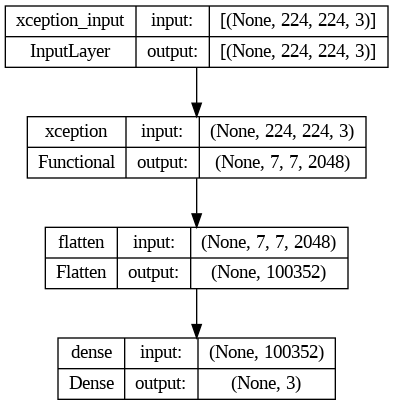

In [25]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

In [26]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=Adam(learning_rate=0.0005),
    metrics=METRICS
)

In [27]:
callbacks = [
    ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, verbose=1, restore_best_weights=True)
]

In [28]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=35,
    callbacks=callbacks,
        verbose=1
    #  , class_weight=class_weights
)

Epoch 1/35
48/48 [==============================] - ETA: 0s - loss: 0.5081 - accuracy: 0.8253 - precision: 0.8769 - recall: 0.7614 - auc: 0.9430 - f1_score: 0.8253
Epoch 1: val_accuracy improved from -inf to 0.86758, saving model to best_model.keras
48/48 [==============================] - 267s 5s/step - loss: 0.5081 - accuracy: 0.8253 - precision: 0.8769 - recall: 0.7614 - auc: 0.9430 - f1_score: 0.8253 - val_loss: 0.3296 - val_accuracy: 0.8676 - val_precision: 0.8791 - val_recall: 0.8630 - val_auc: 0.9728 - val_f1_score: 0.8676
Epoch 2/35
48/48 [==============================] - ETA: 0s - loss: 0.2498 - accuracy: 0.9205 - precision: 0.9339 - recall: 0.8840 - auc: 0.9838 - f1_score: 0.9205
Epoch 2: val_accuracy did not improve from 0.86758
48/48 [==============================] - 259s 5s/step - loss: 0.2498 - accuracy: 0.9205 - precision: 0.9339 - recall: 0.8840 - auc: 0.9838 - f1_score: 0.9205 - val_loss: 0.5447 - val_accuracy: 0.8082 - val_precision: 0.8082 - val_recall: 0.8082 - va

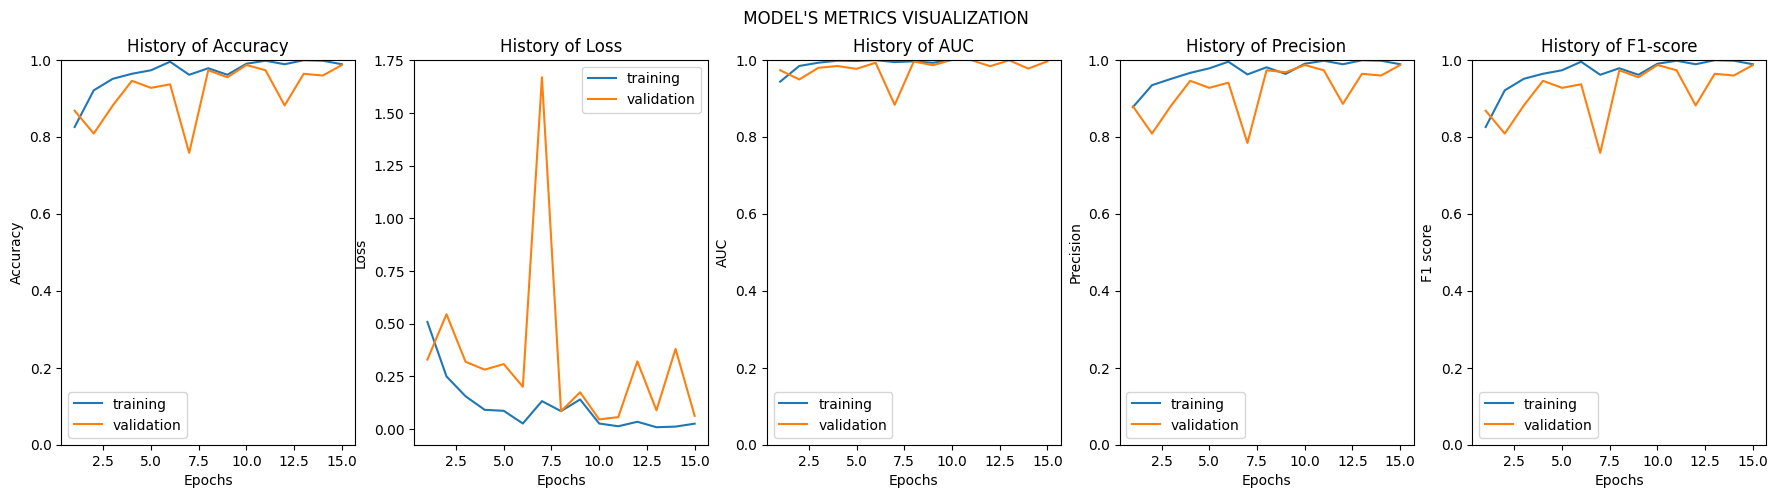

In [29]:
def Train_Val_Plot(acc, val_acc, loss, val_loss, auc, val_auc, precision, val_precision, f1, val_f1):

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(22, 5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    # Rescale the y-axis for accuracy, auc, precision, and f1
    rescale_factor = 0  # Adjust this factor to control the rescaling

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1.0])
    ax1.legend(['training', 'validation'])

    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.set_ylim([rescale_factor, 1.0])
    ax3.legend(['training', 'validation'])

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.set_ylim([rescale_factor, 1.0])
    ax4.legend(['training', 'validation'])

    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.set_ylim([rescale_factor, 1.0])
    ax5.legend(['training', 'validation'])

    plt.show()

# Example usage:
Train_Val_Plot(history.history['accuracy'], history.history['val_accuracy'],
               history.history['loss'], history.history['val_loss']
               ,
               history.history['auc'], history.history['val_auc'],
               history.history['precision'], history.history['val_precision'],
               history.history['f1_score'], history.history['val_f1_score'])


In [30]:
model.evaluate(test_generator)

7/7 [==============================] - 6s 917ms/step - loss: 0.0271 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_score: 1.0000


[0.02710551954805851, 1.0, 1.0, 1.0, 1.0, 1.0]

In [31]:
# Load the test dataset
X_test, y_test = [], []
for i in range(len(validation_generator)):
    batch_X, batch_y = validation_generator[i]
    X_test.append(batch_X)
    y_test.append(batch_y)
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the one-hot encoded predictions to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert the one-hot encoded true labels to class labels
y_true_classes = np.argmax(y_test, axis=1)

# Create a classification report
report = classification_report(y_true_classes, y_pred_classes)

print(report)

7/7 [==============================] - 15s 2s/step
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       1.00      1.00      1.00       112
           2       0.98      0.99      0.98        83

    accuracy                           0.99       219
   macro avg       0.98      0.97      0.97       219
weighted avg       0.99      0.99      0.99       219



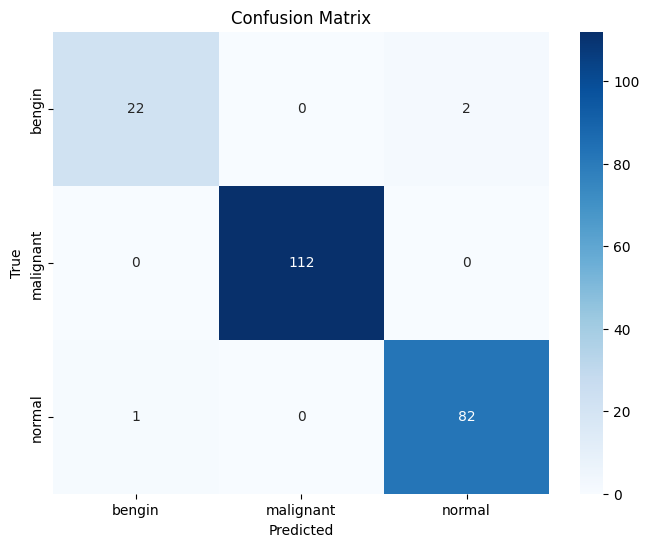

In [32]:

class_names = ['bengin', 'malignant', 'normal']
# Create a confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
